## Building a CIFAR Classifier


Using what we have learned, let's build a simple CIFAR image classifier.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

cuda0 = torch.device('cuda:0')

torch.manual_seed(1234)  # for reproducibility


### Loading Data

The [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) library provides a wide range of standard vision datasets and networks with pretrained weights. We will use [the `torchvision.datasets.CIFAR` class](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10) to easily access the CIFAR dataset.

In [ ]:
import torchvision

cifar_train = torchvision.datasets.CIFAR10(root='./data', download=True, train=True)

100%|██████████| 170498071/170498071 [00:07<00:00, 22262710.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Each element of the dataset is a 2-tuple, consisting of the image of the digit, and its label. E.g.,

This is a truck:


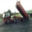

In [ ]:
image, label = cifar_train[2]
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('This is a {}:'.format(label_names[label]))
image

In [ ]:
type(image)

PIL.Image.Image

The image is given as a `PIL.Image`. To automatically obtain a `torch.Tensor`, we can add a [`torchvision.transforms.ToTensor` ](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) transform when constructing the dataset:

In [ ]:
cifar_train = torchvision.datasets.CIFAR10(root='./data', download=True, train=True,
                                         transform=torchvision.transforms.ToTensor())  # the ToTensor transform converts PIL.Image to torch.Tensor

Files already downloaded and verified


In [ ]:
image, label = cifar_train[13]
print(type(image))
print(image.shape)  # CIFAR images are 32x32, and have a 3 color channels representing RGB

<class 'torch.Tensor'>
torch.Size([3, 32, 32])


In [ ]:
print('This image has max={}'.format(image.max()), 'and min={}'.format(image.min()))

This image has max=0.95686274766922 and min=0.0


In deep learning, it is often a good idea to normalize network inputs to be centered around zero. We use the [`torchvision.transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) tranform to achieve this. Adding this transform, we construct the dataset as:

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),  # [0, 1] range => [-1, 1] range
])

cifar_train = torchvision.datasets.CIFAR10(root='./data', download=True, train=True,
                                         transform=transform)
cifar_val = torchvision.datasets.CIFAR10(root='./data', download=True, train=False,
                                         transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('training set size:\t{}'.format(len(cifar_train)))
print('validation set size:\t{}'.format(len(cifar_val)))

training set size:	50000
validation set size:	10000


We use the PyTorch `torch.utils.data.DataLoader` to automatically load batched data.

In [ ]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(cifar_train,
                                           batch_size=batch_size,
                                           shuffle=True,                   # shuffle training set
                                           num_workers=4,                  # turns on multi-processing loading so training is not blocked by data loading
                                           pin_memory=True)                # pin_memory allows faster transfer from CPU to GPU
val_loader = torch.utils.data.DataLoader(cifar_val,
                                         batch_size=batch_size,
                                         num_workers=4,
                                         pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Each element yielded by `train_loader` (a Python iterable) is still a 2-tuple,
# but now consisting of a batched image tensor, and a batched label tensor.

images, labels = next(iter(train_loader))
print('batched image tensor shape: {}'.format(images.shape))
print('batched label tensor shape: {}'.format(labels.shape))

batched image tensor shape: torch.Size([512, 3, 32, 32])
batched label tensor shape: torch.Size([512])


### Building the Network

We will use a convolutional network for classification. The following architecture is a simple convnet with strided convolutions and relu nonlinearities.

The input is a 3 color channel image and the output is a 10 dimensional vector that will be interpreted as the score of each of the 10 possible classes.

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1) # 32x32 --> 16x16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1) # 16x16 --> 8x8
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1) # 8x8 --> 4x4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) # 4x4 --> 2x2
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=10, kernel_size=4, stride=2, padding=1) # 2x2 --> 1x1

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.conv5(out).squeeze()

        return out

In [ ]:
net = MyNet().to(cuda0)

In [ ]:
# This network output a size 10 vector for each input image, as verified below
# using a random input tensor.

net(torch.randn(32, 3, 32, 32, device=cuda0)).shape

torch.Size([32, 10])

### Training Loop


For classification, we will use the cross-entropy loss [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) to train this network.

We can write a function that iterates through the training set (via `train_loader`) and train for 1 epoch.

The next exercise is to fill in the code below. You can use the following pytorch functions:

* put data on GPU: [to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html?highlight=#torch.to)
* clear gradient: [zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html?highlight=zero_grad)
* backward pass: [backward](https://pytorch.org/docs/stable/generated/torch.autograd.backward.html?highlight=backward#torch.autograd.backward)
* update parameters with a gradient step: [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html?highlight=step#torch.optim.Optimizer.step)





In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################

# Fix the places with a `FIXME!!!`

def train(net, optim):
    net.train()
    for image, label in train_loader:
        # put data onto GPU
        # FIXME!!!

        # clear gradient
        # FIXME!!!

        # forward through the network
        # FIXME!!!

        # compute loss and gradient
        # FIXME!!! Check the `F.cross_entropy` documentation linked above

        # update parameters
        # FIXME!!!

        pass  # FIXME!!! Remove this `pass` when you are done.

Let's also write a function that evaluates our network on the validation set.

In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################

# Fix the places with a `FIXME!!!`


def evaluate(net):
    total = 0
    correct = 0

    net.eval()  # puts the network in eval mode. this is important when the
                # network has layers that behaves differently in training and
                # evaluation time, e.g., dropout and batch norm.
    for image, label in val_loader:
        # put data onto GPU
        # FIXME!!!

        with torch.no_grad():  # gradients are not tracked in this context manager
                               # since we are evaluating, gradients are not needed
                               # and we can save some time and GPU memory.

            # forward through the network, and get the predicted class
            # FIXME!!!  (HINT: use .argmax(dim=-1))
            #   `prediction` should be an integer vector of size equal to the batch size.
            #   Remember that the network outputs logits of the prediction probabilities,
            #   and that the higher the logits, the higher the probability.
            prediction = None

            total += image.size(0)  # batch size
            correct += (prediction == label).sum().item()  # `.item()` retreives a python number from a 1-element tensor

    return correct / total

In [ ]:
# Without any training, the network accuracy matches that of random guessing: ~10%.

print('At initialization, the network has accuracy {:.4f}%'.format(evaluate(net) * 100))

### Putting Everything Together

In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################


# Fix the places with a `FIXME!!!`


num_epochs = 10
lr = 0.1

optim = None  # FIXME!!! Construct an optimizer (e.g., SGD) to optimize the network parameters with the above learning rate

for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(net) * 100))
    train(net, optim)

print('Done! \tValidation Accuracy: {:.4f}%'.format(evaluate(net) * 100))

## Open-ended Exercises

1. What could you do to make the accuracy higher and/or the training faster?  
2. Adapt the code for another dataset (e.g., CIFAR-100 from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html)).
3. How many samples are actually needed to train a good CIFAR classifier? Try subsample the training set (sampled a fraction of images per class) and plot validation accuracy vs. training set size.
5. Use the [fast-gradient sign method](https://arxiv.org/abs/1412.6572) to attack your CIFAR classifier! Why does your super great classifier now fail at a seemingly normal image?